## Load the model from Hugging Face Hub:

In [1]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
from torchvision.utils import make_grid

ckpt_name = 'aehrc/cxrmate'

dataset_dir = '/datasets/work/hb-mlaifsp-mm/work/datasets'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_decoder = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True).to(device)
encoder_decoder.eval()
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name)
image_processor = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name)

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor.size['shortest_edge'],
            image_processor.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std,
        ),
    ]
)

/apps/python/3.9.4/lib/python3.9/site-packages/scipy-1.6.2-py3.9-linux-x86_64.egg/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal fo

/home/nic261/.cache/huggingface/modules/transformers_modules/aehrc/cxrmate/1f014633b98564f21316b32e167b5796381690d8/modelling_longitudinal.py:158: UserWarning: The encoder-to-decoder model was not warm-started before applying low-rank approximation.
  warnings.warn('The encoder-to-decoder model was not warm-started before applying low-rank approximation.')


trainable params: 147456 || all params: 80916528 || trainable%: 0.18223223814051934


/datasets/work/hb-mlaifsp-mm/work/environments/cxrmate/lib/python3.9/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


## The images for the first study of each patient:

In [2]:
# Images from the first study of Patient 1:
image_1 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s59968351/9eef23a6-9ec5cac1-17521310-3e505395-c63ed35d.jpg'))
image_1 = image_1.convert('RGB')

image_2 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s59968351/ae032259-83a5d5ec-8bce36ad-8313ec75-f32fb108.jpg'))
image_2 = image_2.convert('RGB')

# Images from the first study of Patient 2:
image_3 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s59968351/9eef23a6-9ec5cac1-17521310-3e505395-c63ed35d.jpg'))
image_3 = image_3.convert('RGB')

image_4 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s59968351/ae032259-83a5d5ec-8bce36ad-8313ec75-f32fb108.jpg'))
image_4 = image_4.convert('RGB')

image_1 = test_transforms(image_1)
image_2 = test_transforms(image_2)
image_3 = test_transforms(image_3)
image_4 = test_transforms(image_4)

study_a = torch.stack([image_1, image_2], dim=0)
study_b = torch.stack([image_3, image_4], dim=0)

images = torch.nn.utils.rnn.pad_sequence([study_a, study_b], batch_first=True, padding_value=0.0)
images.shape

torch.Size([2, 2, 3, 384, 384])

### Images from all of the studies:

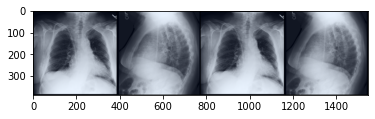

In [3]:
display_images = torch.stack([image_1, image_2, image_3, image_4], dim=0)
plt.imshow(make_grid(display_images, normalize=True).permute(1, 2, 0))

In [4]:
# No previous findings and impression sections available:
previous_findings = [None, None]
previous_impression = [None, None]

# Tokenize prompt:
prompt = encoder_decoder.tokenize_prompt(
    previous_findings, 
    previous_impression, 
    tokenizer, 
    256, 
    add_bos_token_id=True,
)
prompt

{'input_ids': tensor([[ 8, 10,  9, 11,  1],
         [ 8, 10,  9, 11,  1]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1]], device='cuda:0')}

## Generate the reports:

In [5]:
outputs = encoder_decoder.generate(
    pixel_values=images.to(device),
    decoder_input_ids=prompt['input_ids'],
    special_token_ids=[
        tokenizer.additional_special_tokens_ids[
            tokenizer.additional_special_tokens.index('[PMT-SEP]')
        ],
        tokenizer.bos_token_id,
        tokenizer.sep_token_id,
    ],  
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    mask_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    max_length=256 + prompt['input_ids'].shape[1],
    num_beams=4,
)

# An update to generate() now prepends bos_token_id to each sequence if it does not exist at the start of the input: 
#   https://github.com/huggingface/transformers/blob/d533465150532b0c5de167b574e59f64c68b1154/src/transformers/generation/utils.py#L699C13-L699C30
# Hence, we remove the prepended bos_token_id from each sequence if it is there:
if torch.all(outputs.sequences[:, 0] == 1):
    outputs.sequences = outputs.sequences[:, 1:]

outputs.sequences

tensor([[   8,   10,    9,   11,    1,  846,  148,  369,  546,  132,  115,  250,
           23, 2675, 3991,  182,   22,  580,  732,  816,  535,  120,  269,  172,
         1085,  443,  125,  115,  182,  878,   23, 1528,  626, 1074,  269, 1841,
          115,  342,  150,  296, 1284, 1615,  125, 1361,   23,  213,  120,  163,
         1660,  284,  214,  171,   23,  139,  449,  278,  120,  437,  237,  526,
           23, 2310, 1233,  456,  282,  115,  941, 1394,   23,  198,  271,  542,
          578,  120, 1186,   23,    3,  159,  271,  397,  389,   23,    2],
        [   8,   10,    9,   11,    1,  846,  148,  369,  546,  132,  115,  250,
           23, 2675, 3991,  182,   22,  580,  732,  816,  535,  120,  269,  172,
         1085,  443,  125,  115,  182,  878,   23, 1528,  626, 1074,  269, 1841,
          115,  342,  150,  296, 1284, 1615,  125, 1361,   23,  213,  120,  163,
         1660,  284,  214,  171,   23,  139,  449,  278,  120,  437,  237,  526,
           23, 2310, 1233,  456, 

## Decode using the tokenizer:

In [6]:
# Findings and impression sections (exclude previous report):
_, findings, impression = encoder_decoder.split_and_decode_sections(
    outputs.sequences,
    [tokenizer.bos_token_id, tokenizer.sep_token_id, tokenizer.eos_token_id],
    tokenizer
)

for i, j in zip(findings, impression):
    print(f'Findings: {i}\nImpression: {j}\n')

Findings: Frontal and lateral views of the chest. Dual lumen right-sided central venous catheter is seen with distal tip in the right atrium. Increased interstitial markings seen throughout the lungs are unchanged given differences in technique. There is no confluent consolidation or effusion. The cardiomediastinal silhouette is within normal limits. Atherosclerotic calcifications noted at the aortic arch. No acute osseous abnormality is detected.
Impression: No acute cardiopulmonary process.

Findings: Frontal and lateral views of the chest. Dual lumen right-sided central venous catheter is seen with distal tip in the right atrium. Increased interstitial markings seen throughout the lungs are unchanged given differences in technique. There is no confluent consolidation or effusion. The cardiomediastinal silhouette is within normal limits. Atherosclerotic calcifications noted at the aortic arch. No acute osseous abnormality is detected.
Impression: No acute cardiopulmonary process.



## The images for the second study of each patient:

In [7]:
# Images from the second study of Patient 1:
image_1 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s54028344/4a5283d6-157b6054-3840ea3d-d27e7ba1-d6689022.jpg'))
image_1 = image_1.convert('RGB')

image_2 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s54028344/7794e4cb-719a0b85-18532575-0b5ea119-8eb26b6a.jpg'))
image_2 = image_2.convert('RGB')

# Images form the second study from Patient 2:
image_3 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p15/p15131736/s57531802/308bf948-d05f2a1d-2c32a818-2df09584-d17283f6.jpg'))
image_3 = image_3.convert('RGB')

image_1 = test_transforms(image_1)
image_2 = test_transforms(image_2)
image_3 = test_transforms(image_3)

study_a = torch.stack([image_1, image_2], dim=0)
study_b = torch.stack([image_3], dim=0)

images = torch.nn.utils.rnn.pad_sequence([study_a, study_b], batch_first=True, padding_value=0.0)
images.shape

torch.Size([2, 2, 3, 384, 384])

### Images from all of the studies:

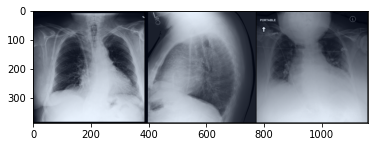

In [8]:
display_images = torch.stack([image_1, image_2, image_3], dim=0)
plt.imshow(make_grid(display_images, normalize=True).permute(1, 2, 0))

## Tokenize the findings and impression sections from the previous studies:

In [9]:
# Previously generated findings and impression sections:
previous_findings = findings
previous_impression = impression

# Tokenize prompt:
prompt = encoder_decoder.tokenize_prompt(
    previous_findings, 
    previous_impression, 
    tokenizer, 
    256, 
    add_bos_token_id=True,
)
prompt

{'input_ids': tensor([[   8,  846,  148,  369,  546,  132,  115,  250,   23, 2675, 3991,  182,
            22,  580,  732,  816,  535,  120,  269,  172, 1085,  443,  125,  115,
           182,  878,   23, 1528,  626, 1074,  269, 1841,  115,  342,  150,  296,
          1284, 1615,  125, 1361,   23,  213,  120,  163, 1660,  284,  214,  171,
            23,  139,  449,  278,  120,  437,  237,  526,   23, 2310, 1233,  456,
           282,  115,  941, 1394,   23,  198,  271,  542,  578,  120, 1186,   23,
             9,  159,  271,  397,  389,   23,    1],
         [   8,  846,  148,  369,  546,  132,  115,  250,   23, 2675, 3991,  182,
            22,  580,  732,  816,  535,  120,  269,  172, 1085,  443,  125,  115,
           182,  878,   23, 1528,  626, 1074,  269, 1841,  115,  342,  150,  296,
          1284, 1615,  125, 1361,   23,  213,  120,  163, 1660,  284,  214,  171,
            23,  139,  449,  278,  120,  437,  237,  526,   23, 2310, 1233,  456,
           282,  115,  941, 1394

## Generate the reports conditioned on the previously generated reports:

In [10]:
outputs = encoder_decoder.generate(
    pixel_values=images.to(device),
    decoder_input_ids=prompt['input_ids'],
    special_token_ids=[
        tokenizer.additional_special_tokens_ids[
            tokenizer.additional_special_tokens.index('[PMT-SEP]')
        ],
        tokenizer.bos_token_id,
        tokenizer.sep_token_id,
    ],  
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    mask_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    max_length=256 + prompt['input_ids'].shape[1],
    num_beams=4,
)

# An update to generate() now prepends bos_token_id to each sequence if it does not exist at the start of the input: 
#   https://github.com/huggingface/transformers/blob/d533465150532b0c5de167b574e59f64c68b1154/src/transformers/generation/utils.py#L699C13-L699C30
# Hence, we remove the prepended bos_token_id from each sequence if it is there:
if torch.all(outputs.sequences[:, 0] == 1):
    outputs.sequences = outputs.sequences[:, 1:]

outputs.sequences

tensor([[   8,  846,  148,  369,  546,  132,  115,  250,   23, 2675, 3991,  182,
           22,  580,  732,  816,  535,  120,  269,  172, 1085,  443,  125,  115,
          182,  878,   23, 1528,  626, 1074,  269, 1841,  115,  342,  150,  296,
         1284, 1615,  125, 1361,   23,  213,  120,  163, 1660,  284,  214,  171,
           23,  139,  449,  278,  120,  437,  237,  526,   23, 2310, 1233,  456,
          282,  115,  941, 1394,   23,  198,  271,  542,  578,  120, 1186,   23,
            9,  159,  271,  397,  389,   23,    1,  846,  148,  369,  546,  132,
          115,  250,  725,  792,   23, 1916,   22, 5093, 1695,   22, 3509,  182,
           22,  580,  732,  816,  535,  739,  282,  115, 1204,  820,  148,  115,
          182,  878,   23,  139,  428,  306,  120,  237,   23,  139,  356,  148,
          386,  349,  150,  489,   23, 1528, 1093,  626, 1074,  150, 1103,  172,
          875,  626,  193,  795,   23,  198,  322,  284,   21,  183,  171,   21,
          214,  211,   23,  

## Decode using the tokenizer:

In [11]:
# Findings and impression sections (exclude previous report):
_, findings, impression = encoder_decoder.split_and_decode_sections(
    outputs.sequences,
    [tokenizer.bos_token_id, tokenizer.sep_token_id, tokenizer.eos_token_id],
    tokenizer
)
for i, j in zip(findings, impression):
    print(f'Findings: {i}\nImpression: {j}\n')

Findings: Frontal and lateral views of the chest were obtained. Large-bore dual-lumen right-sided central venous catheter terminates at the cavoatrial junction and the right atrium. The heart size is normal. The mediastinal and hilar contours are unremarkable. Increased diffuse interstitial markings are compatible with chronic interstitial lung disease. No focal consolidation, pleural effusion, or pneumothorax. No radiopaque foreign body.
Impression: Chronic interstitial lung disease, compatible with chronic interstitial lung disease. No focal consolidation.

Findings: The lung volumes are low. The heart is moderate to severely enlarged. There is moderate pulmonary vascular congestion and mild pulmonary edema. There are likely small bilateral pleural effusions. There is no pneumothorax or focal airspace consolidation worrisome for pneumonia.
Impression: 1. Moderate pulmonary edema. 2. Moderate to severe cardiomegaly and small bilateral pleural effusions.

